In [1]:
from Bio import Entrez
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re

# To make pandas print the entire dataframes:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
# to hide the warnings

from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

# Set up methods and word lists for data mining

In [7]:
# Taken from https://marcobonzanini.com/2015/01/12/searching-pubmed-with-python/ 
# and https://gist.github.com/bonzanini/5a4c39e4c02502a8451d

def search(query, num=20):
    Entrez.email = 'etienne.fortier-dubois@mail.mcgill.ca'
    handle = Entrez.esearch(db = 'pubmed',
                            term = query,
                            sort = 'most+recent',  # 'most+recent' or 'relevance'
                            field = 'Title/Abstract', # in Zhao/Weng: only titles first. What about mesh? synonyms?
                            retmax = str(num),
                            retmode = 'xml',
                            api_key = 'f7e888126cdb64f571c3b61b4decc28a4808'
                           )
    results = Entrez.read(handle)
    return results

def fetch_xml(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'etienne.fortier-dubois@mail.mcgill.ca'
    handle = Entrez.efetch(db = 'pubmed',
                           retmode = 'xml',
                           id = ids,
                           api_key = 'f7e888126cdb64f571c3b61b4decc28a4808'
                          )
    results = Entrez.read(handle)
    return results


In [8]:
# Stating the variables and outcomes to be used in queries. 

# Here are the outcomes. Not sure if I should use MeSHes or regular search terms. 
# The question of synonyms in particular is difficult. 

mesh = '"Vascular Surgical Procedures"[Mesh]'
#with subheadings: 
#'"Vascular Surgical Procedures/mortality"[Mesh]' 
#'"Vascular Surgical Procedures/complications"[Mesh]'

outcomes = [
    "mortality", 
    "infection",
    "readmission", 
    "reintervention",
]

outcomes_synonyms = {"mortality" : ("death",)}

raw_outcomes = ["death", "infection", "readmission_vasc", "reintervention", "composite"]
   

# Here is a list of almost all the features in the dataset, as they appear in the dataset. 
# Most will not be usable directly in queries. Not sure how to deal with this. 

features_raw = [
    "age", "rai_total", "rai_di21", "rai_cancer", "solid_tumors", "hematologic_mal", "sex_male", "rai_sex", 
    "eft_vasc", "dx_cli", "race", "currently_live", "rai_live", "anyone_lives_wu", "additional_assistance", 
    "education", "health", "proc_di", "visual_impaired", "hearing_impaired", "psych_distress", "falls", 
    "fractures", "osteoporosis", "arthritis", "urinary_incontinence", "fecal_incontinence", "height_cm", 
    "weight_kg", "bmi", "food_intake", "rai_appetite", "rai_wtloss", "wtloss_di", "wtloss_3m", "wtloss_12m", 
    "activity", "mobility", "balance", "lifting_10lbs", "fatigued", "satisfied_life", "dropped_activities", 
    "emptiness", "bored", "good_spiritis", "afraid", "happiness", "helpless", "alone", "memory_problems", 
    "liveliness", "worthless", "energy", "hopeless", "better_off", "gds_15", "gds_di_8", "gds_5_total", 
    "gds_5_binary3", "worrier", "nervous", "nervous_thoughts", "gaish_total", "gaish_di", "rai_eating", "eat", 
    "katz_eat", "communicate", "dress", "katz_dress", "appearance", "rai_mobility", "walk_room", "climb_stairs", 
    "transfer", "katz_transfer", "bath", "katz_bath", "rai_toilet", "assistance_toilet", "katz_toileting", 
    "trouble_bathroom", "katz_continence", "rai_hygiene", "brush_teeth", "telephone_use", "lawton_telephone_use", 
    "car_bus_taxi", "lawton_transportation ", "shopping", "lawton_shopping", "prepare_meals", 
    "lawton_food_ preparation", "housework", "lawton_housekeeping", "laundry", "lawton_laundry", "take_rx", 
    "lawton_take_rx", "accounting", "lawton_accounting", "katz_total", "katz_di", "lawton_total", "qol_1", 
    "qol_2", "qol_2_di", "qol_3", "qol_4", "qol_5", "qol_6", "qol_total", "tics_orient_1", "tics_orient_2", 
    "tics_orient_3", "tics_orient_4", "tics_orient_5", "tics_orient_6", "tics_orient_7", "tics_orient_8", 
    "tics_orient_9", "tics_orient_10", "tics_orient_11", "tics_att_12", "tics_att_13", "tics_reg_14", 
    "tics_lang_15", "tics_lang_16", "tics_lang_17", "tics_lang_18", "tics_lang_19", "tics_lang_20", 
    "tics_lang_21", "tics_lang_22", "tics_lang_23", "tics_recall_24", "tics_total", "tics_di_31", "rai_tics", 
    "rai_adls", "mna_a", "mna_b", "mna_c", "mna_d", "mna_e", "mna_f1", "mna_total", "mna_di_11", 
    "GFI_1", "GFI_2", "GFI_3", "GFI_4", "GFI_5", "GFI_6", "GFI_7", "GFI_8", "GFI_9", "GFI_10", "GFI_11", "GFI_12", 
    "GFI_13", "GFI_14", "GFI_15", "GFI_total", 
    "frail_1", "frail_2", "frail_3", "frail_4", "frail_5", "frail_total", 
    "efs_1", "efs_2", "efs_3", "efs_4", "efs_5", "efs_6", "efs_7", "efs_8", "efs_9", "efs_10", "efs_11", 
    "efs_12", "efs_13", "efs_total", "norton_1", "norton_2", "norton_3", "norton_4", "norton_5", "norton_total", 
    "mpi_1", "mpi_2", "mpi_3", "mpi_4", "mpi_5", "mpi_6", "mpi_7", "mpi_8", "mpi_total", "mpi_index", "mFI", 
    "htn", "dlp", "dm", "dm_endorgan", "dm_insulin", "cad", "afib", "anticoag_rx", "chf", "rai_chf", "rai_sob", 
    "cva_tia_stroke", "crf", "rai_crf", "copd_emphesema", "neurospsych", "total_morbidity", "total_3", "total_5", 
    "rx_total", "rx_4", "rx_4_di", "rx_5", "lab_plt", "lab_hgb", "anemia_di", "lab_cr", "rcri", "fu_days", "los", 
    "place_dc", 
    #"death", "reintervention", "readmission_er", "readmission_vasc", "major_vasc", "infection", "composite",
]

kept_features_dict = {
    "age":("age",), "rai_di21":("rai", "risk assessment index"), 
    "solid_tumors":("solid tumors", "cancer"), "hematologic_mal":("hematologic malignancy",), 
    "sex_male":("sex", "male", "female"), 
    "eft_vasc":("eft", "essential frailty toolset"), "dx_cli":("severe disease",), 
    "race":("race", "caucasian", "asian", "black", "hispanic", "native", "indian", "white",), 
    "currently_live":("living at home",), "anyone_lives_wu":("living with someone",), 
    "additional_assistance":("additional assistance",), "education":("education",), "health":("health",), 
    "proc_di":("open surgery", "endovascular surgery"), 
    "visual_impaired":("visual impairment", "visually impaired"), 
    "hearing_impaired":("hearing impairment", "hearing loss"), 
    "psych_distress":("psychological distress",), 
    "falls":("falls",), "fractures":("fractures",), "osteoporosis":("osteoporosis",), "arthritis":("arthritis",), 
    "urinary_incontinence":("urinary incontinence",), "fecal_incontinence":("fecal incontinence",), 
    #"height_cm":("height",), "weight_kg":("weight",), removed, included in bmi
    "bmi":("bmi", "body mass index", "height", "weight"), 
    "food_intake":("food intake",), "rai_appetite":("appetite",), "rai_wtloss":("weight loss",),  
    "activity":("activity",), "mobility":("mobility",), "balance":("balance",), "fatigued":("fatigued",), 
    "satisfied_life":("satisfied life",), 
    "bored":("bored", "boredom",), "good_spiritis":("good spirits",), 
    "afraid":("afraid",), "happiness":("happiness", "happy"), "helpless":("helpless", "helplessness"), 
    "alone":("alone", "lonely", "loneliness"), "memory_problems":("memory problems",), 
    "liveliness":("liveliness",), "worthless":("worthless", "worthlessness"),
    "energy":("energy",), "hopeless":("hopeless", "hopelessness"), 
    "better_off":("better off",), "gds_di_8":("gds", "geriatric depression scale", "depression"), 
    "worrier":("worrier", "worry", "worried"), 
    "nervous":("nervous", "nervousness"), "nervous_thoughts":("nervous thoughts",), 
    "gaish_total":("gaish",), "eat":("eat", "eating"), "communicate":("communicate",), "dress":("dress",), 
    "walk_room":("walk room",), "climb_stairs":("climb stairs",), 
    "transfer":("transfer",), "bath":("bath",), 
    "rai_toilet":("toilet",), "assistance_toilet":("assistance toilet",), 
    "katz_toileting":("toileting",), "trouble_bathroom":("trouble bathroom",), "katz_continence":("continence",), 
    "rai_hygiene":("hygiene",), "brush_teeth":("brush teeth",), "telephone_use":("telephone use",),  
    "lawton_transportation ":("transportation",), "shopping":("shopping",), 
    "prepare_meals":("prepare meals",), "lawton_food_ preparation":("food preparation",), "housework":("housework",), 
    "lawton_housekeeping":("housekeeping",), "laundry":("laundry",), "take_rx":("take medication",), 
    "accounting":("accounting",), "katz_di":("katz",), "lawton_total":("lawton",), "qol_total":("quality of life",), 
    "tics_di_31":("tics", "cognition", "cognitive status"), "rai_adls":("adls", "activities of daily living"), 
    "mna_di_11":("mna", "mini nutritional assessment", "nutrition", "malnutrition"),
    "GFI_total":("gfi", "groningen frailty indicator"),
    "frail_total":("frail", "frailty", "fried frailty scale"), 
    "efs_total":("efs", "edmonton frailty scale"),
    "norton_total":("norton",), 
    "mpi_total":("mpi", "multidimensional prognostic index"),
    "mFI":("mfi", "modified frailty index"), 
    "htn":("hypertension",), "dlp":("dyslipoproteinemia",), 
    "dm":("diabetes", "diabetes mellitus"), "dm_endorgan":("diabetes end organ damage",), 
    "dm_insulin":("diabetes insulin", "insulin"), 
    "cad":("coronary artery disease",), "afib":("atrial fibrillation",), "anticoag_rx":("anticoagulant medication",), 
    "chf":("congestive heart failure",), "rai_sob":("shortness of breath",), 
    "cva_tia_stroke":("cerebral vascular accident", "transient ischemic attack", "stroke"), 
    "crf":("chronic kidney failure", "chronic renal failure"), 
    "copd_emphesema":("chronic obstructive pulmonary disease", "emphysema", "emphesema"), 
    "neurospsych":("neurospsychology",), "total_morbidity":("morbidity", "morbidities"), 
    "rx_5":("medication taken",), "lab_plt":("platelet count",), "lab_hgb":("hemoglobin",), "anemia_di":("anemia",), 
    "lab_cr":("creatine",), "rcri":("revised cardiac risk index",), 
    #"fu_days":("follow-up",)
}

# get the dict values as the list of features to be used from this point on
tuples_into_lists = [list(x) for x in list(kept_features_dict.values())]
features = [item for sublist in tuples_into_lists for item in sublist]

# Subsets of features for the frailty scales

fried_subset = ["frail_1", "frail_2", "frail_3", "frail_4", "frail_5"]
gfi_subset = ["GFI_1", "GFI_2", "GFI_3", "GFI_4", "GFI_5", "GFI_6", "GFI_7", "GFI_8", "GFI_9", "GFI_10", 
              "GFI_11", "GFI_12", "GFI_13", "GFI_14", "GFI_15"]
edmonton_subset = ["efs_1", "efs_2", "efs_3", "efs_4", "efs_5", "efs_6", "efs_7", "efs_8", "efs_9", 
                   "efs_10", "efs_11", "efs_12", "efs_13"]


# These lists contain keywords to characterize co-occurrences as either positive or negative. 
# To make the lists: ask a physician? 

# For now the lists are made from the ones in Zhao and Weng, excluding those that seemed irrelevant. 
# That may or may not be a good way to do it. 

global_positive_keywords = [
    "risk", "link", "associated", "association", "influence", "relation", "relationship", "coexist", "following", 
    "relevance", "complicate", "complicating", "predispose", "predisposing", "clue", "interaction", "cause", 
    "presence", "prevalence", "complicated", "effect", "follow-up", "revelatory", "co-existing", "factor", 
    "evidence", "predicting", "detection", "estimation", "diagnosing", "indicator", "predictor", "management", 
    "appraisal", "monitoring", "predict", "diagnosis", "diagnostic", "evaluating", "prognosis", "index", 
    "correlate", "determination", "measurement", "evaluation", "related", "correlative", "suspected", "promote", 
    "determinant", "augment", "correlation", "impact", "importance", "increased", "induce", "explain", "role", 
    "consistent with", "due to", "resulting from", "result from", "investigation", "symptom", "complicated by", 
    "complicating", "documented", "symptom", "suffering", "significant", "significance", "contributes to", 
    "contribution", "assessment", "suspicious", "hint", "possibility",
]
global_negative_keywords = [
    "differentiation", "differential", "compare", "distinguish", "comparison", "differentiate", "discrimination", 
    "discriminate", "difference", "versus", "reversal", "reduce", "rare", "unrelated", "irrelevant", 
    "unassociated", "unconnected", "irrelative", "independent", "beside the point", "dissimilar",
    "not related", "no relationship", "not associated with", "lack of association", "no association"
]

# These are not done and probably shouldn't be done by me. 
# Also, they will probably need to be done only after the definitive list of features is decided

# Actually, it seems likely I won't be using this approach at all

specific_positive_keywords = {
    "age" : [], 
    "arthritis" : [],
}

specific_negative_keywords = {
    "age" : [], 
    "arthritis" : [],
}


In [9]:
# given a list of the rewritten features, get the corresponding raw features

def get_raw_features(list_of_features): 
    return [x for x in kept_features_dict.keys() if any(y in kept_features_dict[x] for y in list_of_features)]
    

In [10]:
def getAbstracts(query, num=20):
    
    # Searching PubMed and fetching the results
    
    results = search(query, num)
    id_list = results['IdList']
    
    if len(id_list) > 0: 
        print(str(len(id_list)) + " results for " + query)
        papers = fetch_xml(id_list)
    else: 
        print("No results for " + query)
        return []
        
    # Extracting the titles and abstracts and putting them in a list
    
    abstracts = []
    for i, paper in enumerate(papers['PubmedArticle']):
        try: 
            title = paper['MedlineCitation']['Article']['ArticleTitle']
            abstract_string_elements = paper['MedlineCitation']['Article']['Abstract']['AbstractText']
        except KeyError:
            #print("Key error; ignoring this paper.")
            continue
            
        abstract_strings = [str(x) for x in abstract_string_elements]
        abstract = ' '.join(abstract_strings)
        title_abstract = 'TITLE: ' + title + ' ABSTRACT: ' + abstract
        abstracts.append(title_abstract)
    
    return abstracts

In [11]:
# Function to find a keyword in a text (abstract) with some options

# If the whole_words option is enabled, the function uses regexes to make sure to find only whole words;
# otherwise words contained in other words can be found (e.g. relation is within relationship)

# If the distance option is enabled, then the function will return True only if the starting letters of the 
# desired keyword and the other word ("distance_from") are less than or equal to max_distance.

def find_keyword(word, text, whole_words=False, distance=False, distance_from="example", max_distance=100): 
    
    word_regex = re.search(r"\b" + re.escape(word) + r"\b", text)

    if whole_words: 
        if not word_regex: 
            return False
    else: 
        if not word in text: 
            return False
        
    if distance: 
        dist = 0
        if whole_words: 
            other_word_regex = re.search(r"\b" + re.escape(distance_from) + r"\b", text)
            dist = abs(word_regex.span()[0] - word_regex.span()[0])
        else: 
            dist = abs(text.find(word) - text.find(distance_from))
        if dist > max_distance: 
            return False
    
    return True


In [12]:
# Processing abstracts

# Check co-occurrence of two strings in a text
# and calculate score based on presence of keywords 
# (score is either +1, 0, or -1, so either a positive, neutral, or negative abstract)

# Do I need to check for the two words? Or assume they're there since they were obtained from the query?

def calculateScore(text, feature, 
                   glob_pos_keywords = global_positive_keywords, 
                   glob_neg_keywords = global_negative_keywords,
                   spec_pos_keywords = specific_positive_keywords,
                   spec_neg_keywords = specific_negative_keywords
                  ):

    # make abstract lowercase
    text = text.lower()
    
    neither = True # true if neither positive or negative; if both, then we call this "neutral"

    # neither true nor false if there is no co-occurrence
    #if feature not in text or outcome not in text:
    #    return 0, neither
    
    # get keywords (both global and specific to the feature)
    pos_keywords = glob_pos_keywords 
    if (feature in spec_pos_keywords):
        pos_keywords += spec_pos_keywords[feature]
    neg_keywords = glob_neg_keywords
    if (feature in spec_neg_keywords):
        neg_keywords += spec_neg_keywords[feature]
    
    score = 0
    
    # Use this code to calculate score based on presence of at least one pos/neg keyword
    #if any(keyword in text for keyword in pos_keywords):
    #    score += 1
    #    neither = False
    #if any(keyword in text for keyword in neg_keywords):
    #    score -= 1
    #    neither = False
    
    # Use this code to calculate score based on total number of pos/neg keywords
    for keyword in neg_keywords: 
         if find_keyword(keyword, text, whole_words=True, distance=True, distance_from=feature, max_distance=200): 
            score -= 1
            neither = False
            # remove the individual components of the negative keyword from the positive keywords
            # (e.g. if the neg keyword is "lack of association" remove "association" from the pos list)
            individual_words = keyword.split()
            pos_keywords = [x for x in pos_keywords if x not in individual_words]
    for keyword in pos_keywords: 
        if find_keyword(keyword, text, whole_words=True, distance=True, distance_from=feature, max_distance=200):
            score += 1
            neither = False
        
    return score, neither

                 


# Perform the data mining
### This includes a loop over all features and outcomes. It may take a while to run. 

In [8]:
# Can uncomment the following to use a smaller, custom feature or outcomes set

#features = ["health", "healthy", "unhealthy"]
#outcomes = ["mortality"]

In [9]:
# Initializing the arrays to store the results

all_abstracts = [[[]for _ in outcomes] for _ in features]

original_weights = np.zeros((len(features), len(outcomes)+1), dtype=np.int)
positive_abstracts = np.zeros((len(features), len(outcomes)+1), dtype=np.int)
negative_abstracts = np.zeros((len(features), len(outcomes)+1), dtype=np.int)
neutral_abstracts = np.zeros((len(features), len(outcomes)+1), dtype=np.int)
neither_abstracts = np.zeros((len(features), len(outcomes)+1), dtype=np.int)
num_results = np.zeros((len(features), len(outcomes)+1), dtype=np.int)


# Main loop over all features and outcomes

for i in range(len(features)): 
    for j in range(len(outcomes)): 

        feature = features[i]
        outcome = outcomes[j]
        
        query = mesh + ' "' + feature + '" "' + outcome + '"'
        abstracts = getAbstracts(query, num=20000)

        # perform additional queries for synonyms
        if outcome in outcomes_synonyms.keys(): 
            for synonym in outcomes_synonyms[outcome]: 
                query = mesh + ' "' + feature + '" "' + synonym + '"'
                syn_abstracts = getAbstracts(query, num=20000)
                abstracts += syn_abstracts
            # remove any duplicates
            abstracts = list(set(abstracts))

        all_abstracts[i][j] += abstracts
        
        num_results[i, j] = len(abstracts)
        
        positives = 0
        negatives = 0
        neutrals = 0
        for a in abstracts: 
            score, neither = calculateScore(a, feature)
            if score > 0: 
                positives += 1
            if score < 0: 
                negatives += 1
            if neither == False and score == 0: 
                neutrals += 1
        
        # Store results
        positive_abstracts[i, j] = positives
        negative_abstracts[i, j] = negatives
        neutral_abstracts[i, j] = neutrals
        neither_abstracts[i, j] = len(abstracts) - positives - negatives - neutrals
        
        original_weights[i, j] = (positives + 1) / (negatives + 1)


9996 results for "Vascular Surgical Procedures"[Mesh] "age" "mortality"
5250 results for "Vascular Surgical Procedures"[Mesh] "age" "death"
1716 results for "Vascular Surgical Procedures"[Mesh] "age" "infection"
172 results for "Vascular Surgical Procedures"[Mesh] "age" "readmission"
784 results for "Vascular Surgical Procedures"[Mesh] "age" "reintervention"
3 results for "Vascular Surgical Procedures"[Mesh] "rai" "mortality"
3 results for "Vascular Surgical Procedures"[Mesh] "rai" "death"
No results for "Vascular Surgical Procedures"[Mesh] "rai" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "rai" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "rai" "reintervention"
No results for "Vascular Surgical Procedures"[Mesh] "risk assessment index" "mortality"
No results for "Vascular Surgical Procedures"[Mesh] "risk assessment index" "death"
No results for "Vascular Surgical Procedures"[Mesh] "risk assessment index" "infection"
No results for "Vascular Sur

No results for "Vascular Surgical Procedures"[Mesh] "living with someone" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "living with someone" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "living with someone" "reintervention"
1 results for "Vascular Surgical Procedures"[Mesh] "additional assistance" "mortality"
No results for "Vascular Surgical Procedures"[Mesh] "additional assistance" "death"
No results for "Vascular Surgical Procedures"[Mesh] "additional assistance" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "additional assistance" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "additional assistance" "reintervention"
164 results for "Vascular Surgical Procedures"[Mesh] "education" "mortality"
63 results for "Vascular Surgical Procedures"[Mesh] "education" "death"
168 results for "Vascular Surgical Procedures"[Mesh] "education" "infection"
22 results for "Vascular Surgical Procedures"[Mesh] "education" "re

42 results for "Vascular Surgical Procedures"[Mesh] "weight" "reintervention"
3 results for "Vascular Surgical Procedures"[Mesh] "food intake" "mortality"
1 results for "Vascular Surgical Procedures"[Mesh] "food intake" "death"
2 results for "Vascular Surgical Procedures"[Mesh] "food intake" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "food intake" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "food intake" "reintervention"
No results for "Vascular Surgical Procedures"[Mesh] "appetite" "mortality"
2 results for "Vascular Surgical Procedures"[Mesh] "appetite" "death"
4 results for "Vascular Surgical Procedures"[Mesh] "appetite" "infection"
1 results for "Vascular Surgical Procedures"[Mesh] "appetite" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "appetite" "reintervention"
61 results for "Vascular Surgical Procedures"[Mesh] "weight loss" "mortality"
8 results for "Vascular Surgical Procedures"[Mesh] "weight loss" "death"
16 res

1 results for "Vascular Surgical Procedures"[Mesh] "worthless" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "worthless" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "worthless" "reintervention"
1 results for "Vascular Surgical Procedures"[Mesh] "worthlessness" "mortality"
No results for "Vascular Surgical Procedures"[Mesh] "worthlessness" "death"
No results for "Vascular Surgical Procedures"[Mesh] "worthlessness" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "worthlessness" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "worthlessness" "reintervention"
49 results for "Vascular Surgical Procedures"[Mesh] "energy" "mortality"
52 results for "Vascular Surgical Procedures"[Mesh] "energy" "death"
19 results for "Vascular Surgical Procedures"[Mesh] "energy" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "energy" "readmission"
3 results for "Vascular Surgical Procedures"[Mesh] "energy" "reinterventio

326 results for "Vascular Surgical Procedures"[Mesh] "transfer" "mortality"
153 results for "Vascular Surgical Procedures"[Mesh] "transfer" "death"
114 results for "Vascular Surgical Procedures"[Mesh] "transfer" "infection"
13 results for "Vascular Surgical Procedures"[Mesh] "transfer" "readmission"
4 results for "Vascular Surgical Procedures"[Mesh] "transfer" "reintervention"
2 results for "Vascular Surgical Procedures"[Mesh] "bath" "mortality"
2 results for "Vascular Surgical Procedures"[Mesh] "bath" "death"
3 results for "Vascular Surgical Procedures"[Mesh] "bath" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "bath" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "bath" "reintervention"
1 results for "Vascular Surgical Procedures"[Mesh] "toilet" "mortality"
No results for "Vascular Surgical Procedures"[Mesh] "toilet" "death"
No results for "Vascular Surgical Procedures"[Mesh] "toilet" "infection"
No results for "Vascular Surgical Procedures"[Mesh]

312 results for "Vascular Surgical Procedures"[Mesh] "quality of life" "death"
125 results for "Vascular Surgical Procedures"[Mesh] "quality of life" "infection"
18 results for "Vascular Surgical Procedures"[Mesh] "quality of life" "readmission"
44 results for "Vascular Surgical Procedures"[Mesh] "quality of life" "reintervention"
2 results for "Vascular Surgical Procedures"[Mesh] "tics" "mortality"
1 results for "Vascular Surgical Procedures"[Mesh] "tics" "death"
1 results for "Vascular Surgical Procedures"[Mesh] "tics" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "tics" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "tics" "reintervention"
6 results for "Vascular Surgical Procedures"[Mesh] "cognition" "mortality"
6 results for "Vascular Surgical Procedures"[Mesh] "cognition" "death"
1 results for "Vascular Surgical Procedures"[Mesh] "cognition" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "cognition" "readmission"
No results fo

No results for "Vascular Surgical Procedures"[Mesh] "mfi" "reintervention"
7 results for "Vascular Surgical Procedures"[Mesh] "modified frailty index" "mortality"
1 results for "Vascular Surgical Procedures"[Mesh] "modified frailty index" "death"
1 results for "Vascular Surgical Procedures"[Mesh] "modified frailty index" "infection"
1 results for "Vascular Surgical Procedures"[Mesh] "modified frailty index" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "modified frailty index" "reintervention"
2349 results for "Vascular Surgical Procedures"[Mesh] "hypertension" "mortality"
1106 results for "Vascular Surgical Procedures"[Mesh] "hypertension" "death"
278 results for "Vascular Surgical Procedures"[Mesh] "hypertension" "infection"
34 results for "Vascular Surgical Procedures"[Mesh] "hypertension" "readmission"
101 results for "Vascular Surgical Procedures"[Mesh] "hypertension" "reintervention"
1 results for "Vascular Surgical Procedures"[Mesh] "dyslipoproteinemia" "mort

28 results for "Vascular Surgical Procedures"[Mesh] "chronic obstructive pulmonary disease" "reintervention"
2 results for "Vascular Surgical Procedures"[Mesh] "emphysema" "mortality"
5 results for "Vascular Surgical Procedures"[Mesh] "emphysema" "death"
2 results for "Vascular Surgical Procedures"[Mesh] "emphysema" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "emphysema" "readmission"
1 results for "Vascular Surgical Procedures"[Mesh] "emphysema" "reintervention"
No results for "Vascular Surgical Procedures"[Mesh] "emphesema" "mortality"
No results for "Vascular Surgical Procedures"[Mesh] "emphesema" "death"
No results for "Vascular Surgical Procedures"[Mesh] "emphesema" "infection"
No results for "Vascular Surgical Procedures"[Mesh] "emphesema" "readmission"
No results for "Vascular Surgical Procedures"[Mesh] "emphesema" "reintervention"
No results for "Vascular Surgical Procedures"[Mesh] "neurospsychology" "mortality"
No results for "Vascular Surgical Procedures"[

In [10]:
# after looping over all outcomes, fill the last column with an aggregate of the others

for i in range(len(features)): 
    
    # naive method: simple sum
    
    num_results[i, -1] = sum(len(s) for s in all_abstracts[i])
    positive_abstracts[i, -1] = sum(positive_abstracts[i, 0:len(outcomes)])
    negative_abstracts[i, -1] = sum(negative_abstracts[i, 0:len(outcomes)])
    neutral_abstracts[i, -1] = sum(neutral_abstracts[i, 0:len(outcomes)])
    neither_abstracts[i, -1] = sum(neither_abstracts[i, 0:len(outcomes)])
    
    original_weights[i, -1] = (positive_abstracts[i, -1] + 1) / (negative_abstracts[i, -1] + 1)
    
    # Possible other approaches: 
    # union: remove duplicates. Useful? 
    # intersection: only abstracts found in all outcomes (not useful)
    

In [11]:
# Makes all words from a list that appear in a string (abstract) 
# upper case and surrounded by asterisks, to make them easier to locate for humans

def highlight(abstract, word_list): 
    a = abstract
    for w in word_list: 
        a = a.replace(w, '**'+w.upper()+'**')
    return a

# Print an abstract with highlighted words (change the indices to visualize different abstracts)
words = list(outcomes) + features + global_positive_keywords + global_negative_keywords
print(highlight(all_abstracts[0][0][2], words))

TITLE: Multiarterial coronary artery bypass grafting with special reference to small vessel disease and results in women. ABSTRACT: From 1985 to 1991 a total of 220 patients underwent coronary artery bypass grafting (CABG) with at least two **NATIVE** pedicled artery grafts. Bilateral internal mammary artery (IMA) grafting was performed in 201 patients, IMA combined with gastro-epiploic artery (GEA) grafting in five, and double IMA plus GEA grafting in 14; in addition 156 patients received 1-3 vein grafts. The primary indication for elective multi-arterial CABG was coronary arteries of small calibre (small vessel disease) in 77 patients, rep**EAT** CABG in 17 (without small vessel disease), varicose/stripped saphenous veins in 57 (without small vessel disease), while the remaining 69 were routine cases; the distribution differed between women (42, 0, 47, and 11%, respectively) and men (33, 10, 19, and 38%, respectively; P < 0.0001). The women also were older (62 +/- 7 vs 56 +/- 9 years

In [12]:
# Get total number of abstracts in all_abstracts
num_abstracts_per_outcome = [0, 0, 0, 0]
for i in range(len(all_abstracts)): 
    for j in range(len(all_abstracts[i])): 
        num_abstracts_per_outcome[j] += len(all_abstracts[i][j])
print("Number of abstracts for mortality, infection, readmission, reintervention:", num_abstracts_per_outcome)
print("Total:", sum(num_abstracts_per_outcome))

Number of abstracts for mortality, infection, readmission, reintervention: [67468, 9705, 1178, 2774]
Total: 81125


In [13]:
# Make Pandas data frames for ease of manipulation

col_names = outcomes + ['all_outcomes']

num_results_df = pd.DataFrame(num_results, columns=col_names, index=features)
positive_abstracts_df = pd.DataFrame(positive_abstracts, columns=col_names, index=features)
negative_abstracts_df = pd.DataFrame(negative_abstracts, columns=col_names, index=features)
neutral_abstracts_df = pd.DataFrame(neutral_abstracts, columns=col_names, index=features)
neither_abstracts_df = pd.DataFrame(neither_abstracts, columns=col_names, index=features)
original_weights_df = pd.DataFrame(original_weights, columns=col_names, index=features)
#normalized_weights_df = pd.DataFrame(normalized_weights, columns=col_names, index=features)


In [14]:
# To save the results to CSV files

num_results_df.to_csv("Mining_results/num_results.csv", sep=',')
positive_abstracts_df.to_csv("Mining_results/positive_abstracts.csv", sep=',')
negative_abstracts_df.to_csv("Mining_results/negative_abstracts.csv", sep=',')
neutral_abstracts_df.to_csv("Mining_results/neutral_abstracts.csv", sep=',')
neither_abstracts_df.to_csv("Mining_results/neither_abstracts.csv", sep=',')
original_weights_df.to_csv("Mining_results/original_weights.csv", sep=',')


# Analyze and visualize the mining results

In [50]:
# START HERE if you skip the text mining part (but do run the setup cells in the first section)

# To read CSV files

num_results_df = pd.read_csv("Mining_results/num_results.csv", sep=',', index_col=0)
positive_abstracts_df = pd.read_csv("Mining_results/positive_abstracts.csv", sep=',', index_col=0)
negative_abstracts_df = pd.read_csv("Mining_results/negative_abstracts.csv", sep=',', index_col=0)
neutral_abstracts_df = pd.read_csv("Mining_results/neutral_abstracts.csv", sep=',', index_col=0)
neither_abstracts_df = pd.read_csv("Mining_results/neither_abstracts.csv", sep=',', index_col=0)
original_weights_df = pd.read_csv("Mining_results/original_weights.csv", sep=',', index_col=0)


In [51]:
# Reshaping

def reshape(name): 
     return pd.DataFrame({'positive':positive_abstracts_df[name],
                          'negative':negative_abstracts_df[name],
                          'neutral':neutral_abstracts_df[name],
                          'neither':neither_abstracts_df[name],
                          'orig_weights':original_weights_df[name],
                         },
                         columns=['positive', 'negative', 'neutral', 'neither', 'orig_weights'])

mortality_df = reshape('mortality')
infection_df = reshape('infection')
readmission_df = reshape('readmission')
reintervention_df = reshape('reintervention')
all_df = reshape('all_outcomes')

list_of_dfs = [mortality_df, infection_df, readmission_df, reintervention_df, all_df]

In [52]:
# Reshaping and creating the raw feature results

def reshape_and_convert_to_raw(name): 
    positives = np.zeros((len(kept_features_dict)), dtype=np.int)
    negatives = np.zeros((len(kept_features_dict)), dtype=np.int)
    neutrals = np.zeros((len(kept_features_dict)), dtype=np.int)
    neithers = np.zeros((len(kept_features_dict)), dtype=np.int)
    weights = np.zeros((len(kept_features_dict)), dtype=np.int)
    
    for i, raw_feat in enumerate(kept_features_dict.keys()): 
        pos = 0
        neg = 0
        neu = 0
        nei = 0
        for edited_feat in kept_features_dict[raw_feat]: 
            pos += positive_abstracts_df[name][edited_feat]
            neg += negative_abstracts_df[name][edited_feat]
            neu += neutral_abstracts_df[name][edited_feat]
            nei += neither_abstracts_df[name][edited_feat]
        positives[i] = pos
        negatives[i] = neg
        neutrals[i] = neu
        neithers[i] = nei
        weights[i] = (positives[i] + 1) / (negatives[i] + 1)
    
    return pd.DataFrame({'positive':positives,
                         'negative':negatives,
                         'neutral':neutral_abstracts_df[name],
                         'neither':neither_abstracts_df[name],
                         'orig_weights':weights,},
                        index = kept_features_dict.keys(),
                        columns=['positive', 'negative', 'neutral', 'neither', 'orig_weights'])
            
mortality_raw_df = reshape_and_convert_to_raw('mortality')
infection_raw_df = reshape_and_convert_to_raw('infection')
readmission_raw_df = reshape_and_convert_to_raw('readmission')
reintervention_raw_df = reshape_and_convert_to_raw('reintervention')
all_raw_df = reshape_and_convert_to_raw('all_outcomes')

list_of_raw_dfs = [mortality_raw_df, infection_raw_df, readmission_raw_df, reintervention_raw_df, all_raw_df]         

In [53]:
# Normalize the weights

# Normalize the weights per column so that 1.0 is the largest weight
# (I.e. divide each weight by the maximum weight of its column)
# used for bayes net

def normalizeWeights_max1_per_column(weights):
    new_weights = weights.astype(float)
    max_weight = np.amax(new_weights)
    new_weights = np.divide(new_weights, max_weight)
    return new_weights

# Normalize the weights per column so that each columns sums to 1
# (I.e. divide each weight by the sum of the column)
# used for feature selection

def normalizeWeights_total1(weights): 
    new_weights = weights.astype(float)
    weight_sum = np.sum(new_weights)
    new_weights = np.divide(new_weights, weight_sum)
    return new_weights


#print(np.amax(original_weights))
for df in list_of_dfs + list_of_raw_dfs: 
    df['norm_weights_max1'] = normalizeWeights_max1_per_column(df['orig_weights'])
    df['norm_weights_total1'] = normalizeWeights_total1(df['orig_weights'])

In [54]:
# To visualize

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(num_results_df)
#     display(positive_abstracts_df)
#     display(negative_abstracts_df)
#     display(neutral_abstracts_df)
#     display(neither_abstracts_df)
    
#     display(mortality_raw_df)

,mortality,infection,readmission,reintervention,all_outcomes
age,12687,1716,172,784,15359
rai,5,0,0,0,5
risk assessment index,0,0,0,0,0
solid tumors,13,29,0,0,42
cancer,563,465,5,19,1052
hematologic malignancy,10,16,0,0,26
sex,1663,217,44,50,1974
male,2572,466,51,198,3287
female,2294,341,55,101,2791
eft,0,0,0,0,0


In [55]:
# How many variables had at least 1 result?

def no_zeroes(df): 
    df_no_zeroes = df[['positive', 'negative', 'neutral', 'neither']][df.positive + df.negative + df.neutral + df.neither != 0]
    df_no_zeroes['Total'] = df_no_zeroes.sum(axis=1)
    df_no_zeroes = df_no_zeroes.sort_values(by='Total', ascending=False)#[-50:-1]
    print("Features with at least 1 result:", len(df_no_zeroes))
    display(df_no_zeroes)

no_zeroes(mortality_df)
no_zeroes(infection_df)
no_zeroes(readmission_df)
no_zeroes(reintervention_df)
no_zeroes(all_df)

# no_zeroes(mortality_raw_df)
# no_zeroes(infection_raw_df)
# no_zeroes(readmission_raw_df)
# no_zeroes(reintervention_raw_df)
# no_zeroes(all_raw_df)

Features with at least 1 result: 116


,positive,negative,neutral,neither,Total
age,11499,359,575,254,12687
morbidity,8743,255,462,248,9708
stroke,6393,274,501,125,7293
coronary artery disease,4003,140,275,59,4477
diabetes,3363,111,192,30,3696
hypertension,2708,60,114,56,2938
male,2324,72,108,68,2572
female,2082,52,99,61,2294
alone,1965,78,113,35,2191
health,1814,59,85,24,1982


Features with at least 1 result: 84


,positive,negative,neutral,neither,Total
age,1535,45,82,54,1716
morbidity,1071,28,48,18,1165
diabetes,553,12,30,14,609
male,416,11,13,26,466
cancer,418,8,17,22,465
health,386,5,10,4,405
nutrition,343,7,14,12,376
stroke,325,14,23,10,372
female,299,9,12,21,341
hypertension,254,8,7,9,278


Features with at least 1 result: 63


,positive,negative,neutral,neither,Total
age,153,8,9,2,172
health,107,0,4,1,112
morbidity,79,2,9,2,92
stroke,70,4,2,0,76
diabetes,67,2,2,1,72
female,50,2,2,1,55
congestive heart failure,48,2,2,0,52
male,45,2,3,1,51
sex,43,1,0,0,44
coronary artery disease,33,2,4,0,39


Features with at least 1 result: 59


,positive,negative,neutral,neither,Total
age,718,20,39,7,784
morbidity,312,11,21,2,346
stroke,207,6,8,1,222
male,184,5,6,3,198
open surgery,119,3,6,0,128
coronary artery disease,90,7,6,7,110
diabetes,98,4,6,0,108
hypertension,92,2,4,3,101
female,97,1,2,1,101
alone,91,4,2,0,97


Features with at least 1 result: 120


,positive,negative,neutral,neither,Total
age,13905,432,705,317,15359
morbidity,10205,296,540,270,11311
stroke,6995,298,534,136,7963
coronary artery disease,4277,156,290,70,4793
diabetes,4081,129,230,45,4485
hypertension,3085,70,127,69,3351
male,2969,90,130,98,3287
female,2528,64,115,84,2791
health,2354,65,103,30,2552
alone,2294,86,121,42,2543


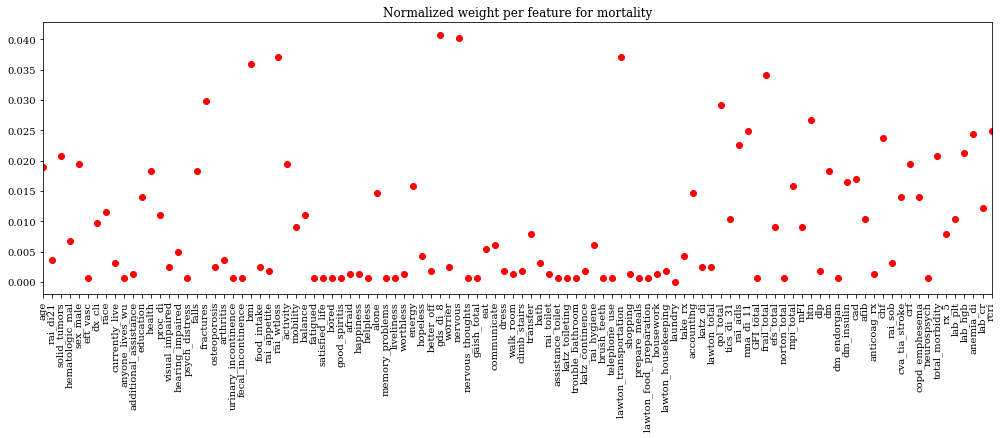

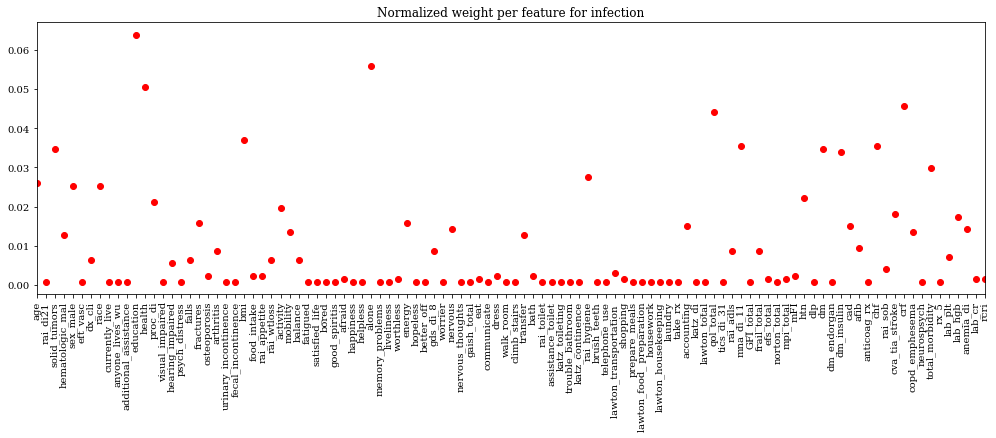

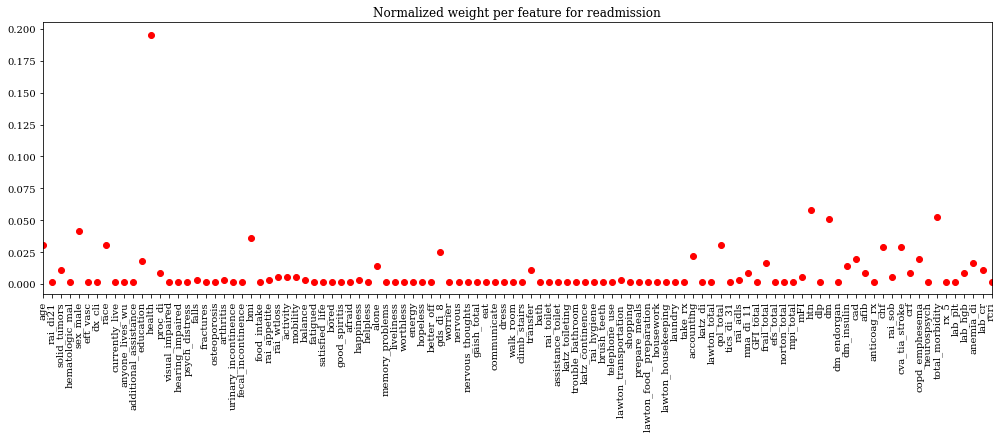

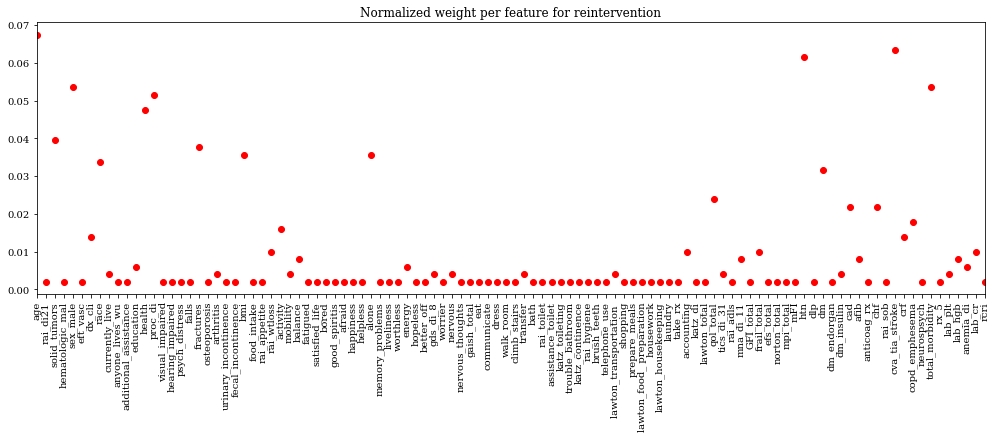

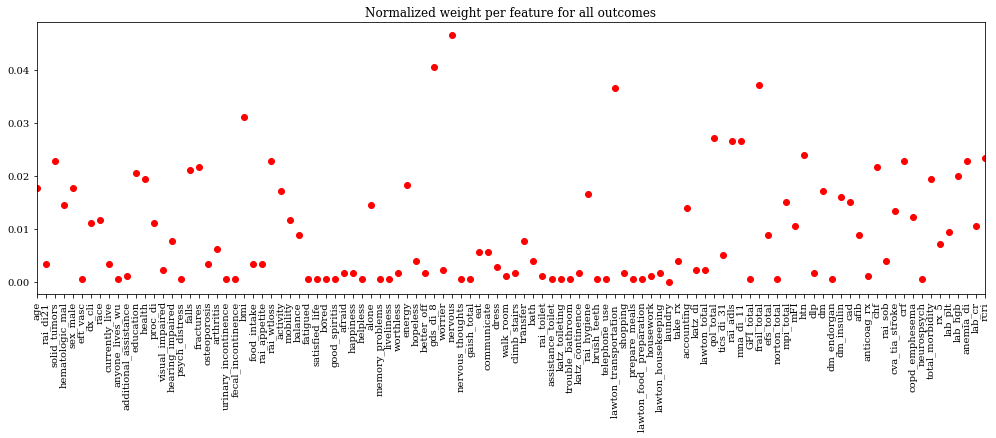

In [56]:
# Plotting 

plt.rcParams['figure.figsize'] = (17,5)

def plots(df, name):
    #no_zeroes = df[['positive', 'negative', 'neutral', 'neither']][df.positive + df.negative + df.neutral + df.neither != 0]
    #no_zeroes.plot.bar(stacked=True)
    #plt.title('Number of abstracts found for "' + name + '" and various keywords')
    #df[['orig_weights']].plot(style='bo')
    #plt.title('Original weight per feature for "' + name + '"')
    #plt.xticks(range(len(df)), df.index.values, rotation=90)
    df[['norm_weights_total1']].plot(style='ro', legend=False)
    plt.title('Normalized weight per feature for ' + name)
    plt.xticks(range(len(df)), df.index.values, rotation=90)
    plt.show()

# plots(mortality_df, "mortality")
# plots(infection_df, "infection")
# plots(readmission_df, "readmission")
# plots(reintervention_df, "reintervention")
# plots(all_df, "all outcomes")

plots(mortality_raw_df, "mortality")
plots(infection_raw_df, "infection")
plots(readmission_raw_df, "readmission")
plots(reintervention_raw_df, "reintervention")
plots(all_raw_df, "all outcomes")


In [57]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))


matplotlib: 2.2.3


<Figure size 1224x360 with 0 Axes>

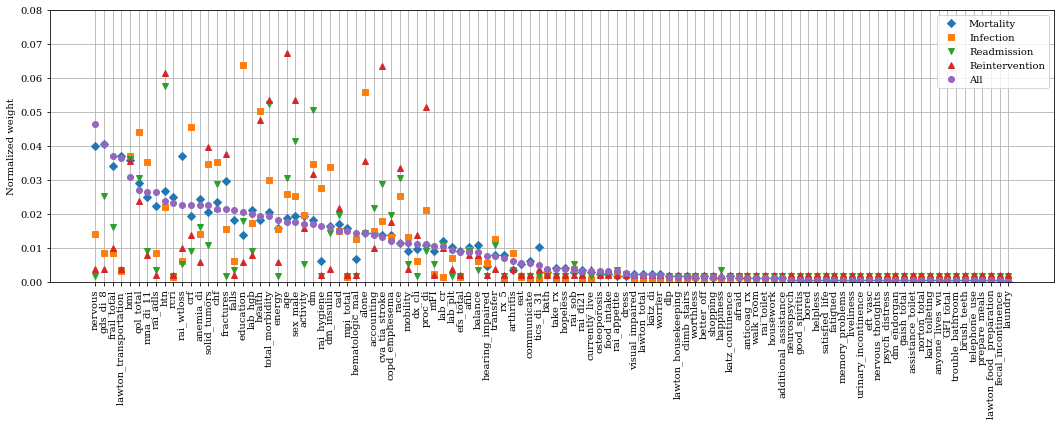

In [58]:
# Plotting all outcomes' weights together

plt.clf()
plt.rcParams['figure.figsize'] = (18,5)

#plt.rc('text', usetex=False)
plt.rc('font', family='serif')

f = plt.figure()

# Reshape back to get all normalized weights in a table by outcome
weights_df = pd.DataFrame({'mortality':mortality_raw_df['norm_weights_total1'],
                           'infection':infection_raw_df['norm_weights_total1'],
                           'readmission':readmission_raw_df['norm_weights_total1'],
                           'reintervention':reintervention_raw_df['norm_weights_total1'],
                           'all':all_raw_df['norm_weights_total1']},
                        index = all_raw_df.index.values,
                        columns=['mortality', 'infection', 'readmission', 'reintervention', 'all'])

sorted_by_all = weights_df.sort_values(by='all', ascending=False)

# feature_names = sorted_by_all.index.values
# plt.xticks(range(len(sorted_by_all[['all']])), feature_names, rotation=90)
    
plt.plot(sorted_by_all[['mortality']], 'D')
plt.plot(sorted_by_all[['infection']], 's')
plt.plot(sorted_by_all[['readmission']], 'v')
plt.plot(sorted_by_all[['reintervention']], '^')
plt.plot(sorted_by_all[['all']], 'o')

#plt.title('For various numbers of features')
plt.xticks(rotation=90)
plt.ylim(0, 0.08)
plt.ylabel('Normalized weight')
#plt.xlabel('Number of features')
plt.legend(['Mortality', 'Infection', 'Readmission', 'Reintervention', 'All'])
plt.grid()

plt.show()

f.savefig("Latex/img/fig_all_weights.pdf", bbox_inches='tight')

In [59]:
# Select the top X variables for a given outcome

def select_topX(df, X=10): 
    return df.norm_weights_total1.sort_values(ascending=False)[0:X]

X=10
# print(select_topX(mortality_df, X))
# print(select_topX(infection_df, X))
# print(select_topX(readmission_df, X))
# print(select_topX(reintervention_df, X))
print(select_topX(all_raw_df, X))


nervous                   0.046641
gds_di_8                  0.040533
frail_total               0.037202
lawton_transportation     0.036646
bmi                       0.031094
qol_total                 0.027207
mna_di_11                 0.026652
rai_adls                  0.026652
htn                       0.023876
rcri                      0.023320
Name: norm_weights_total1, dtype: float64


In [60]:
# Select the variables totalling W% of the weight

def select_percentW(df, W=0.8): 
    sorted_features = df.norm_weights_total1.sort_values(ascending=False)
    
    cumulative_weight = 0.0
    i = 0
    for weight in sorted_features: 
        cumulative_weight += weight
        i += 1
        if cumulative_weight >= W: 
            break
            
    return sorted_features[0:i]


# Example:
w = 0.7
# print(select_percentW(mortality_raw_df, W=w))
# print(select_percentW(infection_raw_df, W=w))
print(select_percentW(readmission_raw_df, W=w))
# print(select_percentW(reintervention_raw_df, W=w))
# print(select_percentW(all_raw_df, W=w).index)


health             0.195298
htn                0.057866
total_morbidity    0.052441
dm                 0.050633
sex_male           0.041591
bmi                0.036166
age                0.030741
race               0.030741
qol_total          0.030741
cva_tia_stroke     0.028933
chf                0.028933
gds_di_8           0.025316
accounting         0.021700
copd_emphesema     0.019892
cad                0.019892
education          0.018083
frail_total        0.016275
Name: norm_weights_total1, dtype: float64


In [61]:
# Calculate the weight for a given number of features (sorted from highest)

def calculate_weight_for_X_features(df, X=10): 
    sorted_features = df.norm_weights_total1.sort_values(ascending=False)
    cumulative_weight = 0.0
    for i in range(X): 
        cumulative_weight += sorted_features[i]
    return cumulative_weight

# Example:
x = 40
print(calculate_weight_for_X_features(all_df, X=x))
print(calculate_weight_for_X_features(all_raw_df, X=x))

0.7027932960893855
0.8300943920044415


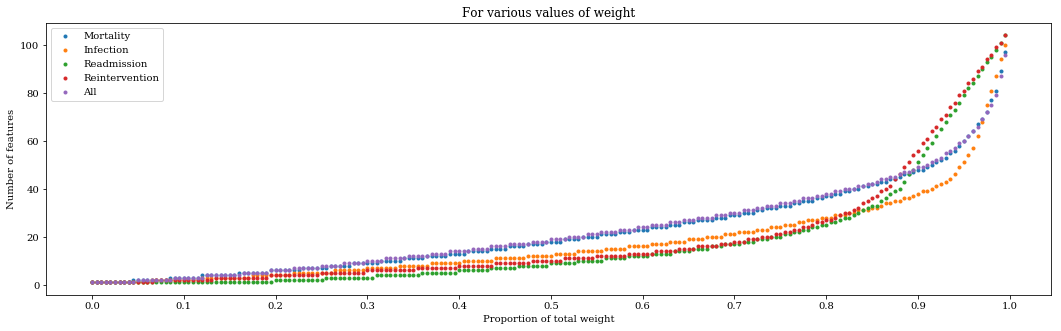

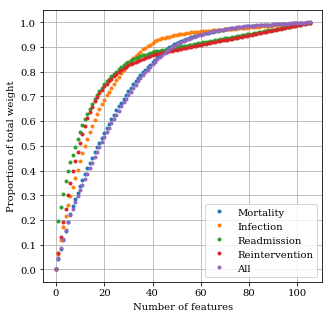

In [62]:
# plotting the number of features vs. the percentage of weight

plt.clf()
plt.rcParams['figure.figsize'] = (5,5)

# version 1: get the number of features for several values of desired weight

weight_percentages = np.arange(0.0, 1.0, 0.005)
numbers_selected_features = np.zeros((len(outcomes)+1, len(weight_percentages)))

for i, df in enumerate(list_of_raw_dfs): 
    for j, w in enumerate(weight_percentages):
        selection = select_percentW(df, W=w)
        numbers_selected_features[i][j] = len(selection)
    plt.plot(weight_percentages, numbers_selected_features[i], '.')
    
plt.title('For various values of weight')
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.xlabel('Proportion of total weight')
plt.ylabel('Number of features')
plt.legend(['Mortality', 'Infection', 'Readmission', 'Reintervention', 'All'])
plt.show()


# version 2: get the weight for several numbers of features

f = plt.figure()

num_features = range(len(kept_features_dict))
cumulative_weights = np.zeros((len(outcomes)+1, len(num_features)))

for i, df in enumerate(list_of_raw_dfs): 
    for x in num_features:
        cumulative_weights[i][x] = calculate_weight_for_X_features(df, X=x)
    plt.plot(num_features, cumulative_weights[i], '.')

#plt.title('For various numbers of features')
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.ylabel('Proportion of total weight')
plt.xlabel('Number of features')
plt.legend(['Mortality', 'Infection', 'Readmission', 'Reintervention', 'All'])
plt.grid()
plt.show()

f.savefig("Latex/img/fig_cumulative.pdf", bbox_inches='tight')

# Import the clinical data

In [63]:
# Importing 

file = 'data/data_train.csv'
train_dataset = pd.read_csv(file, sep=',', header=0)

file = 'data/data_test.csv'
test_dataset = pd.read_csv(file, sep=',', header=0)

# sum the quality of life columns intp qol_total
train_dataset['qol_total'] = train_dataset['qol_1'] + train_dataset['qol_2'] + train_dataset['qol_3'] + train_dataset['qol_4'] + train_dataset['qol_5'] + train_dataset['qol_6']
test_dataset['qol_total'] = test_dataset['qol_1'] + test_dataset['qol_2'] + test_dataset['qol_3'] + test_dataset['qol_4'] + test_dataset['qol_5'] + test_dataset['qol_6']

#to see certain columns
train_dataset.iloc[:, 150:180] 

,mna_di_11,GFI_1,GFI_2,GFI_3,GFI_4,GFI_5,GFI_6,GFI_7,GFI_8,GFI_9,GFI_10,GFI_11,GFI_12,GFI_13,GFI_14,GFI_15,GFI_total,frail_1,frail_2,frail_3,frail_4,frail_5,frail_total,efs_1,efs_2,efs_3,efs_4,efs_5,efs_6,efs_7
0,1,1,1,0,0,1,1,0,0,1,0,0,0,0,1,1,7,1,1,1,0,0,3,2,1,0,1,2,0,0
1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,1,5,0,1,1,1,0,3,2,1,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,3,0,0,1,0,1,2,2,1,0,0,2,0,0
3,1,1,0,0,0,0,0,0,1,0,1,0,1,1,1,1,7,1,0,1,0,0,2,1,1,2,1,2,0,0
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,1,1,1,0,0,3,1,1,1,0,2,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,3,1,1,1,0,0,3,2,1,0,1,0,0,0
6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,1,1,0,0,2,1,1,1,0,0,1,0
7,1,1,0,0,0,1,1,0,0,0,0,0,1,0,1,1,6,1,0,1,1,0,3,2,1,1,0,0,0,0
8,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,4,1,0,1,1,1,4,1,1,0,0,0,0,0
9,1,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,7,1,1,1,1,1,5,1,1,2,1,2,1,1


In [64]:
# function to make desired categorical variables contain only 0 or 1
# currently only affects 'race'
                
def partial_binarize(df): 
    
    df = df.copy()

    for column_name in df.columns: 
        contents = df[column_name]
        values = contents.unique()
        #print(values)
        
        mask = None
        if column_name == 'race': 
            # 1 if white (coded as 1), 0 if not white (coded as 2-8)
            mask = df[column_name] == 1     
        
        if mask is not None: 
            df.loc[mask, column_name] = 1
            df.loc[~mask, column_name] = 0
            continue
        
    return df

train_dataset = partial_binarize(train_dataset)
test_dataset = partial_binarize(test_dataset)

# Logistic regression

In [65]:
# import relevant scikit-learn stuff

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier


In [66]:
# get the ground truth ("y")

mortality_y      = train_dataset['death']
infection_y      = train_dataset['infection']
readmission_y    = train_dataset['readmission_vasc']
reintervention_y = train_dataset['reintervention']
all_y            = train_dataset['composite']

TEST_mortality_y      = test_dataset['death']
TEST_infection_y      = test_dataset['infection']
TEST_readmission_y    = test_dataset['readmission_vasc']
TEST_reintervention_y = test_dataset['reintervention']
TEST_all_y            = test_dataset['composite']

# tuples to be passed to the various models (the last number is W as determined from plots)
y_tuples = [("Mortality", mortality_y, TEST_mortality_y, mortality_raw_df, 0.9), 
            ("Infection", infection_y, TEST_infection_y, infection_raw_df, 0.92), 
            ("Readmission", readmission_y, TEST_readmission_y, readmission_raw_df, 0.83), 
            ("Reintervention", reintervention_y, TEST_reintervention_y, reintervention_raw_df, 0.82), 
            ("All outcomes", all_y, TEST_all_y, all_raw_df, 0.9), ]
        

In [67]:
# logistic regression with a very large C (1e42) to ensure no regularization
# no cross-validation

def no_regularization_model(x, y): 
    
    # Missing data
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imp.fit_transform(x)
    
    clf = LogisticRegression(C=1e42, solver='liblinear', max_iter=1000)
    clf.fit(X, y)
    
    return clf


In [68]:
# x should be the original train dataset, but with only the 106 kept features
# y should be the correct outcome column (mortality_y, etc.)
# mode should be either 'regularization' or 'literature'

def folds_regularization_model(x, y, ll): 
    
    # Select subset and complete missing data
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imp.fit_transform(x)
    
    # Values to test for the regularization parameter
    C_values = [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
    
    # list to hold the best C for each of the 18 folds
    best_Cs = []
    
    outer_folds = KFold(n_splits=18)
    for train_index_outer, test_index_outer in outer_folds.split(X):
        X_train_outer, X_test_outer = X[train_index_outer], X[test_index_outer]
        #y_train_outer, y_test_outer = y[train_index_outer], y[test_index_outer]
        
        # list to hold the performance of each C value
        average_performances = []
        
        # for each value of C, divide the rest into 17 folds, and average the validation performance
        for c in C_values: 
            
            train_fbetas = []
            test_fbetas = []
            
            inner_folds = KFold(n_splits=17)
            for train_index_inner, test_index_inner in inner_folds.split(X_train_outer):
                X_train_inner, X_test_inner = X[train_index_inner], X[test_index_inner]
                y_train_inner, y_test_inner = y[train_index_inner], y[test_index_inner]
                
                # classifier
                clf = LogisticRegression(C=c, penalty=ll, solver='liblinear', max_iter=1000)
                clf.fit(X_train_inner, y_train_inner)
                train_predictions = clf.predict(X_train_inner)
                test_predictions = clf.predict(X_test_inner)
                
                # computing performance
                train_fbeta = metric(y_train_inner, train_predictions)
                test_fbeta = metric(y_test_inner, test_predictions)
                train_fbetas += [train_fbeta]
                test_fbetas += [test_fbeta]
                
                # TODO: log
                #print("Train:", train_fbeta)
                #print("Test: ", test_fbeta)
            
            average_test_fbeta = sum(test_fbetas) / 17
            average_performances += [average_test_fbeta]
            
        max_index = np.argmax(average_performances)
        best_C = C_values[max_index]
        best_Cs += [best_C]
        
    # At this point we have obtained the best C value for each of the 18 outer folds, 
    # computed from the 17 inner folds in each case. We haven't used the 18 folds except for dividing. 
    # Now we'll use them. 
    
    # remove duplicates
    best_Cs = list(set(best_Cs))
    print("Best values of C based on the inner folds:", best_Cs)
    
    # list to hold the performance of each C value
    average_performances = []
    
    for c in best_Cs: 
        
        train_fbetas = []
        test_fbetas = []
            
        for train_index_outer, test_index_outer in outer_folds.split(X):
            X_train_outer, X_test_outer = X[train_index_outer], X[test_index_outer]
            y_train_outer, y_test_outer = y[train_index_outer], y[test_index_outer]
            
            # classifier
            clf = LogisticRegression(C=c, penalty=ll, solver='liblinear', max_iter=1000)
            clf.fit(X_train_outer, y_train_outer)
            train_predictions = clf.predict(X_train_outer)
            test_predictions = clf.predict(X_test_outer)
                
            # computing performance
            train_fbeta = metric(y_train_outer, train_predictions)
            test_fbeta = metric(y_test_outer, test_predictions)
            train_fbetas += [train_fbeta]
            test_fbetas += [test_fbeta]
                
            # TODO: log
            #print("Train:", train_fbeta)
            #print("Test: ", test_fbeta)
            
        average_test_fbeta = sum(test_fbetas) / 18
        average_performances += [average_test_fbeta]
            
    print("Average performances:", average_performances)
    max_index = np.argmax(average_performances)
    final_best_C = best_Cs[max_index]
    
    # we have found the best C value! train a classifier on the whole train dataset to get the coeffs
    
    clf = LogisticRegression(C=final_best_C, penalty=ll, solver='liblinear', max_iter=1000)
    clf.fit(X, y)
    predictions = clf.predict(X)
    
    return final_best_C, clf
            


In [69]:
# x should be the original train dataset, but with only the 106 kept features
# y should be the correct outcome column (mortality_y, etc.)
# weight_df should be the corresponding dataframe (mortality_raw_df, etc.)

def folds_weight_model(x, y, weight_df): 
    
    # Missing data (this transforms the Pandas df into a numpy array, so I do it repeatedly below to work with dfs)
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imp.fit_transform(x)
    
    # Values to test for the proportion of literature weight
    W_values = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
                   0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
    
    # list to hold the best W for each of the 18 folds
    best_Ws = []
    
    outer_folds = KFold(n_splits=18)
    for train_index_outer, test_index_outer in outer_folds.split(X):
        X_train_outer, X_test_outer = X[train_index_outer], X[test_index_outer]
        #y_train_outer, y_test_outer = y[train_index_outer], y[test_index_outer]
        
        # list to hold the performance of each C value
        average_performances = []
        
        # for each value of C, divide the rest into 17 folds, and average the validation performance
        for w in W_values: 
            
            # Select features
            features = select_percentW(weight_df, W=w).index
            x_selected = x[features]
            # Missing data
            X = imp.fit_transform(x_selected)
            
            train_fbetas = []
            test_fbetas = []
            
            inner_folds = KFold(n_splits=17)
            for train_index_inner, test_index_inner in inner_folds.split(X_train_outer):
                X_train_inner, X_test_inner = X[train_index_inner], X[test_index_inner]
                y_train_inner, y_test_inner = y[train_index_inner], y[test_index_inner]
                    
                # classifier
                clf = LogisticRegression(C=1e42, solver='liblinear', max_iter=1000) # very large C == no regularization
                clf.fit(X_train_inner, y_train_inner)
                train_predictions = clf.predict(X_train_inner)
                test_predictions = clf.predict(X_test_inner)

                # computing performance
                train_fbeta = metric(y_train_inner, train_predictions)
                test_fbeta = metric(y_test_inner, test_predictions)
                train_fbetas += [train_fbeta]
                test_fbetas += [test_fbeta]
                
                # TODO: log
                #print("Train:", train_fbeta)
                #print("Test: ", test_fbeta)
            
            average_test_fbeta = sum(test_fbetas) / 17
            average_performances += [average_test_fbeta]
            
        max_index = np.argmax(average_performances)
        best_W = W_values[max_index]
        best_Ws += [best_W]
        
    # At this point we have obtained the best W value for each of the 18 outer folds, 
    # computed from the 17 inner folds in each case. We haven't used the 18 folds except for dividing. 
    # Now we'll use them. 
    
    # remove duplicates
    best_Ws = list(set(best_Ws))
    print("Best values of W based on the inner folds:", best_Ws)
    
    # list to hold the performance of each W value
    average_performances = []
    
    for w in best_Ws: 
        
        # Select features
        features = select_percentW(weight_df, W=w).index
        x_selected = x[features]
        # Missing data
        X = imp.fit_transform(x_selected)
        
        train_fbetas = []
        test_fbetas = []
            
        for train_index_outer, test_index_outer in outer_folds.split(X):
            X_train_outer, X_test_outer = X[train_index_outer], X[test_index_outer]
            y_train_outer, y_test_outer = y[train_index_outer], y[test_index_outer]
            
            # classifier
            clf = LogisticRegression(C=1e42, solver='liblinear', max_iter=1000)
            clf.fit(X_train_outer, y_train_outer)
            train_predictions = clf.predict(X_train_outer)
            test_predictions = clf.predict(X_test_outer)
                
            # computing performance
            train_fbeta = metric(y_train_outer, train_predictions)
            test_fbeta = metric(y_test_outer, test_predictions)
            train_fbetas += [train_fbeta]
            test_fbetas += [test_fbeta]
                
            # TODO: log
            #print("Train:", train_fbeta)
            #print("Test: ", test_fbeta)
            
        average_test_fbeta = sum(test_fbetas) / 18
        average_performances += [average_test_fbeta]
            
    print("Average performances:", average_performances)
    max_index = np.argmax(average_performances)
    final_best_W = best_Ws[max_index]
    
    # we have found the best W value! train a classifier on the whole train dataset to get the coeffs
    
    # Select features
    features = select_percentW(weight_df, W=final_best_W).index
    x_selected = x[features]
    # Missing data
    X = imp.fit_transform(x_selected)
    
    clf = LogisticRegression(C=1e42, solver='liblinear', max_iter=1000)
    clf.fit(X, y)
    
    return final_best_W, clf
            

In [70]:
def predefined_weight_model(x, y, w, weight_df): 
    
    # Select features
    features = select_percentW(weight_df, W=w).index
    x_selected = x[features]
    
    # Missing data
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imp.fit_transform(x_selected)
    
    clf = LogisticRegression(C=1e42, solver='liblinear', max_iter=1000)
    clf.fit(X, y)
    
    return clf
    

In [71]:
# Given a pre-trained classifier and some data, computes the desired metric

def metric(y, pred): 
    #return metrics.precision_recall_fscore_support(y, pred, average='weighted')[2]
    #return metrics.balanced_accuracy_score(y, pred)
    #return metrics.recall_score(y, pred, average='macro') # other way to get balanced accuracy
    return metrics.balanced_accuracy_score(y, pred)

def metric_details(y, pred):
    return metrics.recall_score(y, pred, average='macro'), metrics.balanced_accuracy_score(y, pred), metrics.f1_score(y, pred), metrics.confusion_matrix(y, pred)

def compute_performance(clf, x, y, w=-1.0, weight_df=None): 
    
    # Select features 
    if w >= 0.0: 
        features = select_percentW(weight_df, W=w).index
        x = x[features]
    
    # Missing data
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imp.fit_transform(x)
    
    predictions = clf.predict(X)
    performance = metric(y, predictions)
    
    return performance, predictions


# This computes composite predictions from a list of predictions, and returns its F Score compared to some y

def compute_composite_performance(prediction_list, y): 
    
    composite_predictions = np.logical_or.reduce(prediction_list)
    composite_predictions = list(composite_predictions.astype(int))
    
    performance = metric(y, composite_predictions)
        
    return performance, composite_predictions

In [73]:
# Executing the above classifiers 

x_train = train_dataset[list(kept_features_dict.keys())]
x_test = test_dataset[list(kept_features_dict.keys())]

# hold the predictions for the true composite model
no_reg_train_pred = []
no_reg_test_pred = []
l1_reg_train_pred = []
l1_reg_test_pred = []
l2_reg_train_pred = []
l2_reg_test_pred = []
weights_folds_train_pred = []
weights_folds_test_pred = []
weights_plot_train_pred = []
weights_plot_test_pred = []
random_train_pred = []
random_test_pred = []

# hold the regularization coefficients
l1_coefs = []
l2_coefs = []

for outcome, y_train, y_test, weight_df, w_plot in y_tuples: 
    print(outcome)
    
    print("No regularization")
    clf = no_regularization_model(x_train, y_train)
    train_performance, train_predictions = compute_performance(clf, x_train, y_train)
    test_performance, test_predictions = compute_performance(clf, x_test, y_test)
    no_reg_train_pred += [train_predictions]
    no_reg_test_pred += [test_predictions]
    print("Train performance:", train_performance)
    print("Test performance:", test_performance)
    print("Test metric details:", metric_details(y_test, test_predictions))
    print()
    
    if (outcome=='Mortality'): 
        print("Skipping cross-validated models due to insufficient data")
    else: 
        print("With L1 regularization (cross-validation for C)")
        C, clf = folds_regularization_model(x_train, y_train, 'l1')
        print("Best value of C overall:", C)
        train_performance, train_predictions = compute_performance(clf, x_train, y_train)
        test_performance, test_predictions = compute_performance(clf, x_test, y_test)
        l1_reg_train_pred += [train_predictions]
        l1_reg_test_pred += [test_predictions]
        print("Train performance:", train_performance)
        print("Test performance:", test_performance)
        print("Test metric details:", metric_details(y_test, test_predictions))
        print("Coefficients of the logistic regression:")
        print(clf.coef_)
        l1_coefs += [clf.coef_]
        print()

        print("With L2 regularization (cross-validation for C)")
        C, clf = folds_regularization_model(x_train, y_train, 'l2')
        print("Best value of C overall:", C)
        train_performance, train_predictions = compute_performance(clf, x_train, y_train)
        test_performance, test_predictions = compute_performance(clf, x_test, y_test)
        l2_reg_train_pred += [train_predictions]
        l2_reg_test_pred += [test_predictions]
        print("Train performance:", train_performance)
        print("Test performance:", test_performance)
        print("Test metric details:", metric_details(y_test, test_predictions))
        print("Coefficients of the logistic regression:")
        print(clf.coef_)
        l2_coefs += [clf.coef_]
        print()

        print("With weighting (cross-validation for W)")
        W, clf = folds_weight_model(x_train, y_train, weight_df)
        print("Best value of W overall:", W)
        train_performance, train_predictions = compute_performance(clf, x_train, y_train, W, weight_df)
        test_performance, test_predictions = compute_performance(clf, x_test, y_test, W, weight_df)
        weights_folds_train_pred += [train_predictions]
        weights_folds_test_pred += [test_predictions]
        print("Train performance:", train_performance)
        print("Test performance:", test_performance)
        print("Test metric details:", metric_details(y_test, test_predictions))
        print("Features selected:")
        print(select_percentW(weight_df, W).index)
    print()
    
    print("With weighting (W determined from plot)")
    clf = predefined_weight_model(x_train, y_train, w_plot, weight_df)
    print("Value approximated from plot:", w_plot)
    train_performance, train_predictions = compute_performance(clf, x_train, y_train, w_plot, weight_df)
    test_performance, test_predictions = compute_performance(clf, x_test, y_test, w_plot, weight_df)
    weights_plot_train_pred += [train_predictions]
    weights_plot_test_pred += [test_predictions]
    print("Train performance:", train_performance)
    print("Test performance:", test_performance)
    print("Test metric details:", metric_details(y_test, test_predictions))
    print()
    
    print("Random classifier(prior-weighted)")
    clf = DummyClassifier(strategy='stratified',random_state=2)
    clf.fit(x_train, y_train)
    train_performance, train_predictions = compute_performance(clf, x_train, y_train)
    test_performance, test_predictions = compute_performance(clf, x_test, y_test)
    random_train_pred += [train_predictions]
    random_test_pred += [test_predictions]
    print("Train performance:", train_performance)
    print("Test performance:", test_performance)
    print("Test metric details:", metric_details(y_test, test_predictions))
    print()
    print()

# The following uses the classifiers for each of the outcomes except the last ('all') to make predictions 
# and compare them to the composite outcome in the dataset
print("Aggregated composite model")
print("No regularization")
train_perf, train_pred = compute_composite_performance(no_reg_train_pred[0:-1], all_y)
test_perf, test_pred = compute_composite_performance(no_reg_test_pred[0:-1], TEST_all_y)
print("Train performance:", train_perf)
print("Test performance:", test_perf)
print("Test metric details:", metric_details(TEST_all_y, test_pred))

print("With L1 regularization (cross-validation for C)")
train_perf, train_pred = compute_composite_performance(l1_reg_train_pred[0:-1], all_y)
test_perf, test_pred = compute_composite_performance(l1_reg_test_pred[0:-1], TEST_all_y)
print("Train performance:", train_perf)
print("Test performance:", test_perf)
print("Test metric details:", metric_details(TEST_all_y, test_pred))

print("With L2 regularization (cross-validation for C)")
train_perf, train_pred = compute_composite_performance(l2_reg_train_pred[0:-1], all_y)
test_perf, test_pred = compute_composite_performance(l2_reg_test_pred[0:-1], TEST_all_y)
print("Train performance:", train_perf)
print("Test performance:", test_perf)
print("Test metric details:", metric_details(TEST_all_y, test_pred))

print("With weighting (cross-validation for W)")
train_perf, train_pred = compute_composite_performance(weights_folds_train_pred[0:-1], all_y)
test_perf, test_pred = compute_composite_performance(weights_folds_test_pred[0:-1], TEST_all_y)
print("Train performance:", train_perf)
print("Test performance:", test_perf)
print("Test metric details:", metric_details(TEST_all_y, test_pred))

print("With weighting (W determined from plot)")
train_perf, train_pred = compute_composite_performance(weights_plot_train_pred[0:-1], all_y)
test_perf, test_pred = compute_composite_performance(weights_plot_test_pred[0:-1], TEST_all_y)
print("Train performance:", train_perf)
print("Test performance:", test_perf)
print("Test metric details:", metric_details(TEST_all_y, test_pred))

print("Random (prior-weighted)")
train_perf, train_pred = compute_composite_performance(random_train_pred[0:-1], all_y)
test_perf, test_pred = compute_composite_performance(random_test_pred[0:-1], TEST_all_y)
print("Train performance:", train_perf)
print("Test performance:", test_perf)
print("Test metric details:", metric_details(TEST_all_y, test_pred))


Mortality
No regularization
Train performance: 1.0
Test performance: 0.4918032786885246
Test metric details: (0.4918032786885246, 0.4918032786885246, 0.0, array([[60,  1],
       [ 8,  0]]))

Skipping cross-validated models due to insufficient data

With weighting (W determined from plot)
Value approximated from plot: 0.9
Train performance: 1.0
Test performance: 0.4918032786885246
Test metric details: (0.4918032786885246, 0.4918032786885246, 0.0, array([[60,  1],
       [ 8,  0]]))

Random classifier(prior-weighted)
Train performance: 0.49295774647887325
Test performance: 0.4918032786885246
Test metric details: (0.4918032786885246, 0.4918032786885246, 0.0, array([[60,  1],
       [ 8,  0]]))


Infection
No regularization
Train performance: 1.0
Test performance: 0.5556318681318682
Test metric details: (0.5556318681318682, 0.5556318681318682, 0.28571428571428575, array([[45, 11],
       [ 9,  4]]))

With L1 regularization (cross-validation for C)


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

Best values of C based on the inner folds: [1, 100]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Average performances: [0.8055555555555556, 0.7916666666666666]
Best value of C overall: 1
Train performance: 0.85
Test performance: 0.5171703296703297
Test metric details: (0.5171703296703297, 0.5171703296703297, 0.22222222222222224, array([[45, 11],
       [10,  3]]))
Coefficients of the logistic regression:
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
  -1.06587766  1.58859354  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.12216288
   0.         -0.49326106 -0.00227384  0.          0.          0.15596113
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.23463696  0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.        

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

Best values of C based on the inner folds: [0.1]
Average performances: [0.8148148148148148]
Best value of C overall: 0.1
Train performance: 0.85
Test performance: 0.5171703296703297
Test metric details: (0.5171703296703297, 0.5171703296703297, 0.22222222222222224, array([[45, 11],
       [10,  3]]))
Coefficients of the logistic regression:
[[-2.36736261e-03 -5.73602387e-02 -4.79102429e-02 -1.61354093e-03
   7.17131322e-02 -8.51361708e-03  1.15856859e-01  5.68494970e-02
  -2.70138586e-02 -4.36093529e-02 -2.08538503e-03 -3.59142000e-02
  -2.36278279e-01  1.84312933e-01  9.17285842e-02  2.59865411e-02
   2.01505294e-02 -3.68468917e-02 -4.46147611e-02 -1.47628650e-02
  -1.54588005e-02  9.81036873e-03 -8.00852239e-03  1.41416190e-01
   6.69383600e-02 -1.87529862e-01 -5.57741070e-02 -7.12231081e-02
   8.17881835e-02  1.31482556e-01  3.20629264e-02 -6.51542497e-02
  -1.24628601e-01  2.85303080e-02 -6.23373038e-02  1.85274094e-02
   1.41098967e-02  1.09482192e-02 -4.42778080e-02 -7.52220364e-0

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

Best values of W based on the inner folds: [1.0]
Average performances: [0.7824074074074074]
Best value of W overall: 1.0
Train performance: 1.0
Test performance: 0.5556318681318682
Test metric details: (0.5556318681318682, 0.5556318681318682, 0.28571428571428575, array([[45, 11],
       [ 9,  4]]))
Features selected:
Index(['education', 'alone', 'health', 'crf', 'qol_total', 'bmi', 'mna_di_11',
       'chf', 'solid_tumors', 'dm',
       ...
       'helpless', 'happiness', 'brush_teeth', 'good_spiritis', 'bored',
       'satisfied_life', 'fatigued', 'telephone_use', 'prepare_meals',
       'walk_room'],
      dtype='object', length=106)

With weighting (W determined from plot)
Value approximated from plot: 0.92
Train performance: 1.0
Test performance: 0.6504120879120879
Test metric details: (0.6504120879120879, 0.6504120879120879, 0.42857142857142855, array([[47,  9],
       [ 7,  6]]))

Random classifier(prior-weighted)
Train performance: 0.5096774193548387
Test performance: 0.44642857

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

Best values of C based on the inner folds: [1000]
Average performances: [0.8611111111111112]
Best value of C overall: 1000
Train performance: 1.0
Test performance: 0.5119047619047619
Test metric details: (0.5119047619047619, 0.5119047619047619, 0.125, array([[54,  9],
       [ 5,  1]]))
Coefficients of the logistic regression:
[[-1.50197892e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.00556016e+00  1.20775627e+00  7.36291912e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.83598792e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.52630674e-01
   0.00000000e+00  0.00000000e+00 -1.80251872e-02 -6.40027333e-01
   0.00000000e+00  4.42577245e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.000000

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

Best values of C based on the inner folds: [0.0001]
Average performances: [0.8611111111111112]
Best value of C overall: 0.0001
Train performance: 0.5
Test performance: 0.5
Test metric details: (0.5, 0.5, 0.0, array([[63,  0],
       [ 6,  0]]))
Coefficients of the logistic regression:
[[-5.17245084e-03 -6.67521052e-05 -6.28282203e-05 -9.50066126e-06
   7.79727180e-05  1.52098039e-04  7.82908973e-05  5.74050179e-06
  -1.67572365e-05  5.83050031e-06  2.91281205e-05 -4.70738357e-04
  -2.99484013e-04  1.37270856e-04 -3.17125592e-05  1.75776161e-04
   6.63603083e-05 -2.44866230e-05 -5.73886957e-05 -3.99095609e-05
   1.77751035e-05 -1.29574386e-04 -6.02177150e-06 -2.94179526e-03
  -6.06513508e-05 -1.86859948e-04 -1.85025575e-05 -3.47491713e-04
  -1.53624053e-04  8.98858816e-05 -2.09571398e-06 -7.26176366e-05
  -9.04392457e-05  4.47158381e-05 -7.27144039e-05  5.79008692e-05
  -1.75764810e-05  9.36630118e-05  1.55127539e-05 -5.23250356e-05
  -5.07617156e-06 -5.27188983e-05 -6.87176148e-05  4.5

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

Best values of W based on the inner folds: [0]
Average performances: [0.8611111111111112]
Best value of W overall: 0
Train performance: 0.5
Test performance: 0.5
Test metric details: (0.5, 0.5, 0.0, array([[63,  0],
       [ 6,  0]]))
Features selected:
Index(['health'], dtype='object')

With weighting (W determined from plot)
Value approximated from plot: 0.83
Train performance: 1.0
Test performance: 0.5198412698412699
Test metric details: (0.5198412698412699, 0.5198412698412699, 0.13333333333333333, array([[55,  8],
       [ 5,  1]]))

Random classifier(prior-weighted)
Train performance: 0.4626865671641791
Test performance: 0.4603174603174603
Test metric details: (0.4603174603174603, 0.4603174603174603, 0.0, array([[58,  5],
       [ 6,  0]]))


Reintervention
No regularization
Train performance: 1.0
Test performance: 0.6430555555555555
Test metric details: (0.6430555555555555, 0.6430555555555555, 0.5666666666666667, array([[26, 19],
       [ 7, 17]]))

With L1 regularization (cross-

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

Best values of C based on the inner folds: [0.01]
Average performances: [0.5601851851851852]
Best value of C overall: 0.01
Train performance: 0.5587234042553192
Test performance: 0.5597222222222222
Test metric details: (0.5597222222222222, 0.5597222222222222, 0.30303030303030304, array([[41,  4],
       [19,  5]]))
Coefficients of the logistic regression:
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.       

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Best values of C based on the inner folds: [0.01]
Average performances: [0.5740740740740741]
Best value of C overall: 0.01
Train performance: 0.6480851063829787
Test performance: 0.6319444444444444
Test metric details: (0.6319444444444444, 0.6319444444444444, 0.4736842105263159, array([[40,  5],
       [15,  9]]))
Coefficients of the logistic regression:
[[-0.01533461  0.01207099  0.01179399 -0.0043054   0.0369334   0.02027706
   0.02716511 -0.00528599  0.00145029  0.01719113 -0.00348616 -0.04764467
   0.0310481   0.02149048  0.00107358  0.00787863 -0.00570611  0.01703317
  -0.0008755  -0.00574547 -0.00419652 -0.00107078 -0.00164556 -0.03998651
   0.00796776 -0.01778149  0.02323598  0.01059312 -0.00404183  0.00375593
  -0.00924669 -0.01374158 -0.01007226 -0.00328451 -0.02644707  0.00580226
  -0.01673856  0.03072231 -0.0080466   0.0217464   0.01758006 -0.01299165
  -0.00053085 -0.00297875 -0.00976656 -0.01415342  0.00062386  0.00745899
  -0.03512726  0.00502457  0.00232054 -0.00901232  

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Best values of W based on the inner folds: [0.75]
Average performances: [0.662037037037037]
Best value of W overall: 0.75
Train performance: 0.8268085106382979
Test performance: 0.5833333333333333
Test metric details: (0.5833333333333333, 0.5833333333333333, 0.47058823529411764, array([[30, 15],
       [12, 12]]))
Features selected:
Index(['age', 'cva_tia_stroke', 'htn', 'total_morbidity', 'sex_male',
       'proc_di', 'health', 'solid_tumors', 'fractures', 'alone', 'bmi',
       'race', 'dm', 'qol_total', 'cad', 'chf', 'copd_emphesema', 'activity',
       'crf', 'dx_cli', 'rai_wtloss'],
      dtype='object')

With weighting (W determined from plot)
Value approximated from plot: 0.82
Train performance: 1.0
Test performance: 0.5777777777777777
Test metric details: (0.5777777777777777, 0.5777777777777777, 0.5079365079365079, array([[22, 23],
       [ 8, 16]]))

Random classifier(prior-weighted)
Train performance: 0.4936170212765958
Test performance: 0.4930555555555556
Test metric details

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Best values of C based on the inner folds: [0.0001]
Average performances: [0.6435185185185186]
Best value of C overall: 0.0001
Train performance: 0.6369000786782061
Test performance: 0.5853140916808149
Test metric details: (0.5853140916808149, 0.5853140916808149, 0.4489795918367347, array([[31,  7],
       [20, 11]]))
Coefficients of the logistic regression:
[[-4.93265027e-03  1.08445518e-04  9.00205223e-05 -7.15705167e-05
   4.46327897e-04  2.80205354e-04  4.55793886e-04 -6.19754995e-05
   1.19739231e-05  4.47796614e-05 -7.09901331e-05 -5.05933709e-04
  -1.66829152e-04  4.61739932e-04  6.38617475e-05  1.06759649e-04
  -1.00438962e-04  1.46301127e-04 -9.36204293e-05 -1.25312614e-04
  -2.13397578e-04  6.34728244e-05 -2.73261538e-05 -2.25606104e-04
   6.04749153e-05 -4.78945113e-04  4.36949641e-04 -1.84660084e-04
  -7.38767730e-05  6.63192259e-05 -1.42986760e-04 -2.07260743e-04
  -3.02242630e-04 -8.08422217e-05 -2.70413225e-04  3.47013892e-05
  -5.68992750e-05  3.50846195e-04 -5.52282530

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Best values of W based on the inner folds: [0.75, 0.85]


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


Average performances: [0.5787037037037037, 0.6018518518518517]
Best value of W overall: 0.85
Train performance: 1.0
Test performance: 0.5551782682512734
Test metric details: (0.5551782682512734, 0.5551782682512734, 0.5897435897435898, array([[14, 24],
       [ 8, 23]]))
Features selected:
Index(['nervous', 'gds_di_8', 'frail_total', 'lawton_transportation ', 'bmi',
       'qol_total', 'mna_di_11', 'rai_adls', 'htn', 'rcri', 'crf',
       'rai_wtloss', 'solid_tumors', 'anemia_di', 'chf', 'fractures', 'falls',
       'education', 'lab_hgb', 'health', 'total_morbidity', 'energy',
       'sex_male', 'age', 'activity', 'dm', 'rai_hygiene', 'dm_insulin',
       'mpi_total', 'cad', 'hematologic_mal', 'alone', 'accounting',
       'cva_tia_stroke', 'copd_emphesema', 'mobility', 'race', 'dx_cli',
       'proc_di', 'mFI', 'lab_cr', 'lab_plt'],
      dtype='object')

With weighting (W determined from plot)
Value approximated from plot: 0.9
Train performance: 1.0
Test performance: 0.56833616298811

In [39]:
# Executing the classifiers based only on the features of the various frailty scales

# hold the predictions for the true composite model
fried_reg_train_pred = []
fried_reg_test_pred = []
gfi_reg_train_pred = []
gfi_reg_test_pred = []
efs_reg_train_pred = []
efs_reg_test_pred = []

# hold the regularization coefficients
fried_coefs = []
gfi_coefs = []
efs_coefs = []

for outcome, y_train, y_test, weight_df, w_plot in y_tuples: 
    print(outcome)

    if (outcome=='Mortality'): 
        print("Skipping cross-validated models due to insufficient data")
    else: 
        
        print("With L2 but using only the Fried Frailty Scale features")
        x_train = train_dataset[fried_subset]
        x_test = test_dataset[fried_subset]
        C, clf = folds_regularization_model(x_train, y_train, 'l2')
        print("Best value of C overall:", C)
        train_performance, train_predictions = compute_performance(clf, x_train, y_train)
        test_performance, test_predictions = compute_performance(clf, x_test, y_test)
        fried_reg_train_pred += [train_predictions]
        fried_reg_test_pred += [test_predictions]
        print("Train performance:", train_performance)
        print("Test performance:", test_performance)
        print("Coefficients of the logistic regression:")
        print(clf.coef_)
        fried_coefs += [clf.coef_]
        print()
        
        print("With L2 but using only the Groningen Frailty Indicator features")
        x_train = train_dataset[gfi_subset]
        x_test = test_dataset[gfi_subset]
        C, clf = folds_regularization_model(x_train, y_train, 'l2')
        print("Best value of C overall:", C)
        train_performance, train_predictions = compute_performance(clf, x_train, y_train)
        test_performance, test_predictions = compute_performance(clf, x_test, y_test)
        gfi_reg_train_pred += [train_predictions]
        gfi_reg_test_pred += [test_predictions]
        print("Train performance:", train_performance)
        print("Test performance:", test_performance)
        print("Coefficients of the logistic regression:")
        print(clf.coef_)
        gfi_coefs += [clf.coef_]
        print()
        
        print("With L2 but using only the Edmonton Frailty Scale features")
        x_train = train_dataset[edmonton_subset]
        x_test = test_dataset[edmonton_subset]
        C, clf = folds_regularization_model(x_train, y_train, 'l2')
        print("Best value of C overall:", C)
        train_performance, train_predictions = compute_performance(clf, x_train, y_train)
        test_performance, test_predictions = compute_performance(clf, x_test, y_test)
        efs_reg_train_pred += [train_predictions]
        efs_reg_test_pred += [test_predictions]
        print("Train performance:", train_performance)
        print("Test performance:", test_performance)
        print("Coefficients of the logistic regression:")
        print(clf.coef_)
        efs_coefs += [clf.coef_]
        print()

    print()

# The following uses the classifiers for each of the outcomes except the last ('all') to make predictions 
# and compare them to the composite outcome in the dataset
print("Aggregated composite model")
print("With Fried Frailty Scale")
print("Train performance:", compute_composite_performance(fried_reg_train_pred[0:-1], all_y))
print("Test performance:", compute_composite_performance(fried_reg_test_pred[0:-1], TEST_all_y))
print("With Groningen Frailty Indicator")
print("Train performance:", compute_composite_performance(gfi_reg_train_pred[0:-1], all_y))
print("Test performance:", compute_composite_performance(gfi_reg_test_pred[0:-1], TEST_all_y))
print("With Edmonton Frailty Scale")
print("Train performance:", compute_composite_performance(efs_reg_train_pred[0:-1], all_y))
print("Test performance:", compute_composite_performance(efs_reg_test_pred[0:-1], TEST_all_y))


Mortality
Skipping cross-validated models due to insufficient data

Infection
With L2 but using only the Fried Frailty Scale features
Best values of C based on the inner folds: [1000]
Average performances: [0.75]
Best value of C overall: 1000
Train performance: 0.5
Test performance: 0.5
Coefficients of the logistic regression:
[[ 0.11677722  0.15569815 -1.31719087  0.80582627  0.89559991]]

With L2 but using only the Groningen Frailty Indicator features


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classifica

Best values of C based on the inner folds: [0.1]
Average performances: [0.75]
Best value of C overall: 0.1
Train performance: 0.5
Test performance: 0.5
Coefficients of the logistic regression:
[[-0.20571302  0.0441252  -0.05335371  0.00807209 -0.02294953  0.10415945
   0.01595332 -0.23358852 -0.093389    0.00222482  0.         -0.0904881
  -0.00293043  0.00166664 -0.47332628]]

With L2 but using only the Edmonton Frailty Scale features


KeyboardInterrupt: 

In [67]:
# Look at the L1/L2 coefficients and what features they represent

coeffs = [list(l1_coefs[0][0])] + [list(l1_coefs[1][0])] + [list(l1_coefs[2][0])] + [list(l1_coefs[3][0])] + [list(l2_coefs[0][0])] + [list(l2_coefs[1][0])] + [list(l2_coefs[2][0])] + [list(l2_coefs[3][0])]

coeff_df = pd.DataFrame(coeffs).T.abs()
coeff_df.columns = ['infection l1', 'readmission l1', 'reintervention l1', 'all l1', 
                    'infection l2', 'readmission l2', 'reintervention l2', 'all l2']
coeff_df.index = x_train.columns.values

display(coeff_df.sort_values(by='readmission l1', ascending=False))


,infection l1,readmission l1,reintervention l1,all l1,infection l2,readmission l2,reintervention l2,all l2
nervous_thoughts,0.000000,6.543202,0.000000,0.000000,0.067015,1.593280e-04,1.276575e-06,0.000023
shopping,0.000000,5.422411,0.000000,0.000000,0.002060,3.769452e-04,5.980987e-06,0.000281
copd_emphesema,0.000000,5.152182,0.000000,0.000000,0.090505,1.987673e-04,6.729778e-07,0.000239
education,0.000000,4.850868,0.000000,0.000000,0.035914,4.707384e-04,1.520794e-05,0.000506
balance,0.338768,4.193525,0.000000,0.000000,0.131483,8.988588e-05,6.438155e-06,0.000066
sex_male,0.000000,1.687336,0.000000,0.000000,0.071713,7.797272e-05,5.125022e-07,0.000446
eft_vasc,0.000000,1.382597,0.000000,0.000000,0.008514,1.520980e-04,3.445908e-06,0.000280
rcri,0.000000,1.301736,0.000000,0.000000,0.043131,3.914083e-05,6.494418e-06,0.000127
rx_5,3.525937,0.866324,0.000000,0.000000,0.085733,3.818940e-05,6.456434e-07,0.000264
GFI_total,0.971186,0.864462,0.000000,0.000000,0.257912,1.529924e-04,4.645495e-06,0.001235


# Comparison models (Laura's model, frailty scales)

In [37]:
# compute a score based on Laura's handcrafted model
# return 1 or 0 depending on threshold

def LauraScore(patient): 
    score = 0
    
    if patient['falls'] >= 1: 
        score += 1
    if patient['nervous'] >= 1 or patient['gds_di_8'] >= 1: 
        score += 1
    if patient['mna_di_11'] >= 1: 
        score += 1
    if patient['age'] >= 65: 
        score += 1
    if patient['age'] > 80: 
        score += 1
    if patient['total_morbidity'] >= 3: 
        score += 1
    if patient['bmi'] <= 18.5 or patient['bmi'] >= 30: 
        score += 1
    
    if score >= 4: 
        return 1
    else: 
        return 0

In [38]:

def frailtyScoresPerformance(dataset, y, train_prior): 
    
    # Random
    
    random_50_percent = np.random.randint(2, size=len(y))
    print("Performance of balanced random classifier:", metric(y, random_50_percent))
    
    # Laura's Model
    
    laurascores = []
    for index, patient in dataset.iterrows():
        laurascores += [LauraScore(patient)]
    print("Performance of Laura's Model:", metric(y, laurascores))

    # Existing frailty scores
    
    edmonton = (dataset['efs_total'] >= 9).astype(int) # threshold defined as half max (17)
    fried = (dataset['frail_total'] >= 3).astype(int) # predefined threshold
    mfi = (dataset['mFI'] >= 6).astype(int) # threshold defined as half max (11)
    groningen = (dataset['GFI_total'] >= 4).astype(int) # predefined threshold
    
    print("Performance of Edmonton Frail Scale:", metric(y, edmonton))
    print("Performance of Fried Frailty Scale:", metric(y, fried))
    print("Performance of Modified Frailty Index:", metric(y, mfi))
    print("Performance of Groningen Frailty Indicator:", metric(y, groningen))
    
for outcome, y_train, y_test, weight_df, w in y_tuples: 
    print(outcome)
    print("Training set")
    frailtyScoresPerformance(train_dataset, y_train, y_train)
    print("Test set")
    frailtyScoresPerformance(test_dataset, y_test, y_train)
    print()


Mortality
Training set
Performance of balanced random classifier: 0.2535211267605634
Performance of Laura's Model: 0.3380281690140845
Performance of Edmonton Frail Scale: 0.34507042253521125
Performance of Fried Frailty Scale: 0.7183098591549295
Performance of Modified Frailty Index: 0.45774647887323944
Performance of Groningen Frailty Indicator: 0.704225352112676
Test set
Performance of balanced random classifier: 0.3463114754098361
Performance of Laura's Model: 0.673155737704918
Performance of Edmonton Frail Scale: 0.6352459016393442
Performance of Fried Frailty Scale: 0.7377049180327868
Performance of Modified Frailty Index: 0.6844262295081966
Performance of Groningen Frailty Indicator: 0.7295081967213115

Infection
Training set
Performance of balanced random classifier: 0.4838709677419355
Performance of Laura's Model: 0.4887096774193548
Performance of Edmonton Frail Scale: 0.5548387096774194
Performance of Fried Frailty Scale: 0.5758064516129032
Performance of Modified Frailty Inde

In [20]:
# function to make columns contain only 0 or 1
        
        ### INCOMPLETE and DEPRECATED ###
        
def binarize(df): 
    
    df = df.copy()

    for column_name in df.columns: 

        contents = df[column_name]
        values = contents.unique()
        #print(values)
        
        # specific cases
        
        mask = None
        
        if column_name == 'age': 
            # 1 if at least 70
            mask = df[column_name] >= 70
            
        elif column_name == 'bmi': 
            # 1 if less than 18.5 (underweight) or above 25 (overweight), otherwise 0
            mask = (df[column_name] > 25) | (df[column_name] < 18.5)
        
        elif column_name == 'race': 
            # 1 if white (coded as 1), 0 if not white (coded as 2-8)
            mask = df[column_name] == 1
        
        elif column_name == 'education': 
            # 1 if less than high school (coded as 1), 0 if at least high school (coded as 2-3)
            mask = df[column_name] == 1
            
        elif column_name == 'health': 
            # 1 if less than average (coded as 1-2), 0 if average or better (coded as 3-5)
            mask = df[column_name] <= 2
            
        elif column_name == 'total_morbidity': 
            # 1 if at least 1 morbidity
            mask = df[column_name] >= 1
        
        elif column_name == 'lab_hgb': 
            # 1 if less than 120 (hemoglobin lab result)
            mask = df[column_name] < 120
            
        elif column_name == 'rcri': 
            # 1 if more than 2, according to Laura
            mask = df[column_name] > 2
            
        elif column_name == 'efs_total': 
            # Edmonton Frailty Scale: 0-5=not frail, 6-7=vulnerable, 8-9=mild frailty, 10-11=moderate frailty
            mask = df[column_name] >= 8
            
        elif column_name == 'activity': 
            # 0 if ambulant (4), 1 otherwise (1-3)
            mask = df[column_name] < 4
        
        elif column_name == 'mobility': 
            # 0 if full (4), 1 otherwise (1-3)
            mask = df[column_name] < 4
            
        elif column_name == 'balance': 
            # 0 if no problem (1), 1 otherwise (2-3)
            mask = df[column_name] > 1
            
        elif column_name == 'frail_total': 
            # Fried Frailty Scale: score of 3 or more = 1
            mask = df[column_name] >= 3
        
        if mask is not None: 
            df.loc[mask, column_name] = 1
            df.loc[~mask, column_name] = 0
            continue
        
        
        # general cases
        
        if (len(values)==2 and 1 in values and 0 in values or 
              len(values)==3 and 1 in values and 0 in values and np.isnan(np.min(values))):
            # the data is already binary with 0 and 1 (and possibly missing data, i.e. NaN): do nothing
            continue

        elif (len(values)==2 and 0 in values or 
              len(values)==3 and 0 in values and np.isnan(np.min(values))): 
            # we have two values, one of which is 0: turn the other value into 1
            other = np.sort(values)[1]
            df[column_name].replace({other : 1}, inplace=True)
        
        elif (len(values)==2 or
              len(values)==3 and np.isnan(np.min(values))): 
            # we have two values: arbitrarily make one into 0 and the other into 1
            zero = np.sort(values)[0]
            one  = np.sort(values)[1]
            df[column_name].replace({zero : 0, one : 1}, inplace=True)
        
    return df